# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

## Imports

### External Imports

In [51]:
from __future__ import annotations
from typing import TYPE_CHECKING, Any, Callable

import logging
from operator import itemgetter

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

if TYPE_CHECKING:
    from matplotlib.axes._subplots import AxesSubplot
    from matplotlib.lines import Line2D

    _1DArray = np.ndarray[tuple[int], np.dtype[np.float64]]
    _2DArray = np.ndarray[tuple[int, int], np.dtype[np.float64]]
    _NDArray = np.ndarray[tuple[int, ...], np.dtype[np.float64]]
    _TrainResult = tuple[_2DArray, dict[str, int], float]


### Internal Imports

In [52]:
from mlp.data_providers import DataProvider, EMNISTDataProvider, MNISTDataProvider
from mlp.errors import CrossEntropySoftmaxError
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.layers import AffineLayer, DropoutLayer, ReluLayer, SigmoidLayer, SoftmaxLayer
from mlp.learning_rules import AdamLearningRule, GradientDescentLearningRule
from mlp.models import MultipleLayerModel
from mlp.optimisers import Optimiser
from mlp.penalties import L1Penalty, L2Penalty


## Initialize Variables

### Set up RNG, Logger, and Data

In [53]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.

# Seed a random number generator
seed = 11102019
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider("train", batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider("valid", batch_size=batch_size, rng=rng)


KeysView(<numpy.lib.npyio.NpzFile object at 0x000001F4A1175090>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x000001F4A1174B80>)


### Initialize Metavariables

In [54]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

# setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
# input_dim, output_dim, hidden_dim = 784, 47, 100

# weights_init = GlorotUniformInit(rng=rng)
# biases_init = ConstantInit(0.)
# model = MultipleLayerModel([
#     AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
#     ReluLayer(),
#     AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
#     ReluLayer(),
#     AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
# ])

# error = CrossEntropySoftmaxError()
# # Use a basic gradient descent learning rule
# learning_rule = AdamLearningRule()

# #Remember to use notebook=False when you write a script to be run in a terminal
# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)


### Restore Heavy Data

In [55]:
data_hidden_dim = None
data_hidden_layer = None

data_dropout = None
data_l1 = None
data_l2 = None

data_combined_1 = None
data_combined_2 = None
data_combined_3 = None
data_combined_4 = None
data_combined_5 = None
data_combined_6 = None
data_combined_7 = None
data_combined_8 = None

data_dropout_slow = None
data_l1_slow = None
data_l2_slow = None

data_combined_slow_1 = None
data_combined_slow_2 = None
data_combined_slow_3 = None
data_combined_slow_4 = None
data_combined_slow_5 = None
data_combined_slow_6 = None

%store -r


## Helper Functions

### Create and Run Models

In [56]:
def run_model(
    hidden_dim: int,
    hidden_layer_count: int,
    *,
    learning_rate: float = 1e-3,
    dropout: None | Callable[[], DropoutLayer] = None,
    penalty: Callable[[], None | L1Penalty | L2Penalty] = lambda: None,
) -> _TrainResult:
    """
    Run different models specified in the question.

    Args:
        hidden_dim (int):
            Hidden layer dimension
        hidden_layer_count (int):
            Number of hidden layers. At least 1 hidden layer is required
        learning_rate (float):
            Learning rate. Default 1e-3
        dropout (None | (() -> DropoutLayer)):
            Dropout layer constructor. If `None`, no dropout layers are
            included
        penalty (() -> (None | L1Penalty | L2Penalty)):
            Penalty constructor. If the constructor returns `None`, no penalty
            is applied

    Returns:
        (np.ndarray):
            2D array of statistics
        (dict[str, int]):
            Key-index mapping of all the indices
        (float):
            Run time for this model
    """
    if hidden_layer_count < 1:
        raise ValueError("There must be at least one hidden layer")

    input_dim, output_dim = 784, 47

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.0)

    layers: list[object] = [
        AffineLayer(
            input_dim,
            hidden_dim,
            weights_init,
            biases_init,
            weights_penalty=penalty(),
            biases_penalty=penalty(),
        ),
        ReluLayer(),
    ]
    if dropout is not None:
        layers.append(dropout())
    for _ in range(hidden_layer_count - 1):
        layers += [
            AffineLayer(
                hidden_dim,
                hidden_dim,
                weights_init,
                biases_init,
                weights_penalty=penalty(),
                biases_penalty=penalty(),
            ),
            ReluLayer(),
        ]
        if dropout is not None:
            layers.append(dropout())
    layers.append(
        AffineLayer(
            hidden_dim,
            output_dim,
            weights_init,
            biases_init,
            weights_penalty=penalty(),
            biases_penalty=penalty(),
        )
    )
    model = MultipleLayerModel(layers)

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule(learning_rate=learning_rate)

    # Remember to use notebook=False when you write a script to be run in a terminal
    return train_model_and_plot_stats(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        num_epochs,
        stats_interval,
        notebook=True,
    )


### Train Models and Plot Stats

In [57]:
def train_model_and_plot_stats(
    model: MultipleLayerModel,
    error: CrossEntropySoftmaxError,
    learning_rule: GradientDescentLearningRule,
    train_data: DataProvider,
    valid_data: DataProvider,
    num_epochs: int,
    stats_interval: int,
    notebook: bool = True,
) -> _TrainResult:
    """
    Train model and plot related statistics.

    Args:
        model (MultipleLayerModel):
            A model that is to be trained
        error (CrossEntropySoftmaxError):
            Error calculator
        learning_rule (GradientDescentLearningRule):
            Learning rule
        train_data (DataProvider):
            Data to be used for training
        valid_data (DataProvider):
            Data to be used for validation
        num_epochs (int):
            Number of epochs
        stats_interval (int):
            How often training stats are recorded. Stats are recorded every
            `stats_interval` epochs
        notebook (bool):
            Whether the code is run in a Jupyter notebook. Default `True`

    Returns:
        (np.ndarray):
            2D array of statistics
        (dict[str, int]):
            Key-index mapping of all the indices
        (float):
            Run time for this model
    """
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors: dict[str, Callable[[_NDArray, _NDArray], float]] = {
        "acc": lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()
    }

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        data_monitors,
        notebook=notebook,
    )

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats: _2DArray
    keys: dict[str, int]
    stats, keys, run_time = optimiser.train(
        num_epochs=num_epochs, stats_interval=stats_interval
    )

    # # Plot the change in the validation and training set error over training.
    # fig_1 = plt.figure(figsize=(8, 4))
    # ax_1 = fig_1.add_subplot(111)
    # for k in ['error(train)', 'error(valid)']:
    #     ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
    #               stats[1:, keys[k]], label=k)
    # ax_1.legend(loc=0)
    # ax_1.set_xlabel('Epoch number')

    # # Plot the change in the validation and training set accuracy over training.
    # fig_2 = plt.figure(figsize=(8, 4))
    # ax_2 = fig_2.add_subplot(111)
    # for k in ['acc(train)', 'acc(valid)']:
    #     ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
    #               stats[1:, keys[k]], label=k)
    # ax_2.legend(loc=0)
    # ax_2.set_xlabel('Epoch number')

    # return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
    return stats, keys, run_time


### Generate Pretty Strings

#### Stats String

In [58]:
def gen_stat_str(data: _TrainResult) -> str:
    """
    Generate stat string.
    """
    stats, keys, *_ = data
    # Only print the first time
    sorted_keys = sorted(keys.items(), key=itemgetter(1))
    return ", ".join(f"{k[0]}={v:.2e}" for (k, v) in zip(sorted_keys, stats[-1]))


#### Accuracy Gap String

In [59]:
def gen_acc_gap_str(data: _TrainResult) -> str:
    """
    Generate accuracy and gap string.
    """
    stat: _1DArray = data[0][-1]
    keys = data[1]
    acc = stat[keys["acc(valid)"]]
    gap = stat[keys["error(valid)"]] - stat[keys["error(train)"]]
    return f"Accuracy {acc:.2e}, Gap {gap:.2e}"


### Plot Figures

#### Plot Figure 2 & 3

In [60]:
def plot_fig_2_3(data: dict[int, _TrainResult], prefix: str) -> None:
    """
    Plot utility function for Fig. 2 and 3.
    """
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)

    for i, (t, linestyle) in enumerate({"(train)": "-", "(valid)": "--"}.items()):
        for w, datum in data.items():
            stats, keys, *_ = datum
            if not i:
                # Only print the first time
                print(f"{w}: {gen_stat_str(datum)}")
            ax_1.plot(
                np.arange(1, stats.shape[0]) * stats_interval,
                stats[1:, keys[f"error{t}"]],
                label=f"{prefix} {w}{t}",
                linestyle=linestyle,
            )
            ax_2.plot(
                np.arange(1, stats.shape[0]) * stats_interval,
                stats[1:, keys[f"acc{t}"]],
                label=f"{prefix} {w}{t}",
                linestyle=linestyle,
            )

    ax_1.legend(loc=0)
    ax_1.set_xlabel("Epoch number")
    ax_2.legend(loc=0)
    ax_2.set_xlabel("Epoch number")


#### Plot Figure 4 for Dropout

In [61]:
def plot_fig_4_dropout(data: dict[float, _TrainResult], learning_rate: float) -> None:
    """
    Plot utility function for Fig. 4 dropout.
    """
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    accs: list[float] = []
    gaps: list[float] = []
    for dropout, datum in data.items():
        print(
            f"Dropout {dropout} with learning rate {learning_rate}: "
            f"{gen_acc_gap_str(datum)}"
        )
        stat: _1DArray = datum[0][-1]
        keys = datum[1]
        accs.append(stat[keys["acc(valid)"]])
        gaps.append(stat[keys["error(valid)"]] - stat[keys["error(train)"]])

    l1 = ax1.plot(data.keys(), accs, "r", label="Val. Acc.")
    l2 = ax2.plot(data.keys(), gaps, "b", label="Gap")
    lines = l1 + l2
    labels = [l.get_label() for l in lines]

    ax1.legend(lines, labels, loc=0)
    ax1.set_xlabel("Dropout value")
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Generalization gap")


#### Plot Figure 4 for Penalty

In [62]:
def plot_fig_4_penalty_l(
    data: dict[float, _TrainResult],
    type_: str,
    learning_rate: float,
    axes: tuple[AxesSubplot, AxesSubplot],
) -> tuple[list[Line2D], list[Line2D]]:
    """
    Plot utility function for Fig.4 penalty for one of L1/L2.
    """
    accs: list[float] = []
    gaps: list[float] = []
    for value, datum in data.items():
        print(
            f"{type_} {value} with learning rate {learning_rate}: "
            f"{gen_acc_gap_str(datum)}"
        )
        stat: _1DArray = datum[0][-1]
        keys = datum[1]
        accs.append(stat[keys["acc(valid)"]])
        gaps.append(stat[keys["error(valid)"]] - stat[keys["error(train)"]])

    ax1, ax2 = axes
    acc = ax1.plot(data.keys(), accs, label=f"{type_} Val. Acc.")
    gap = ax2.plot(data.keys(), gaps, label=f"{type_} Gap")
    return acc, gap


def plot_fig_4_penalty(
    data_l1: dict[float, _TrainResult],
    data_l2: dict[float, _TrainResult],
    learning_rate: float,
) -> None:
    """
    Plot utility function for Fig. 4 penalty.
    """
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    l1_acc, l1_gap = plot_fig_4_penalty_l(data_l1, "L1", learning_rate, (ax1, ax2))
    l2_acc, l2_gap = plot_fig_4_penalty_l(data_l2, "L2", learning_rate, (ax1, ax2))

    lines = l1_acc + l1_gap + l2_acc + l2_gap
    labels = [l.get_label() for l in lines]

    ax1.legend(lines, labels, loc=0)
    ax1.set_xscale("log")
    ax1.set_xlabel("Penalty value")
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Generalization gap")


#### Plot Validation Data Stats

In [63]:
def plot_fig_valid(data: dict[float, _TrainResult], prefix: str) -> None:
    """
    Plot utility function accuracy and error stats for validation data.
    """
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)

    for w, datum in data.items():
        stats, keys, *_ = datum
        # Only print the first time
        print(f"{w}: {gen_stat_str(datum)}")
        ax_1.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys["error(valid)"]],
            label=f"{prefix} {w}(valid)",
        )
        ax_2.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys["acc(valid)"]],
            label=f"{prefix} {w}(valid)",
        )

    ax_1.legend(loc=0)
    ax_1.set_xlabel("Epoch number")
    ax_2.legend(loc=0)
    ax_2.set_xlabel("Epoch number")


## Run Models

### 0.1 Learning Rate

#### Varying Hidden Layer Dimensions

Dimension 32 run time: 284.407 seconds
Dimension 64 run time: 438.091 seconds
Dimension 128 run time: 656.241 seconds
32: error(train)=5.65e-01, acc(train)=8.20e-01, error(valid)=7.17e-01, acc(valid)=7.85e-01
64: error(train)=3.37e-01, acc(train)=8.82e-01, error(valid)=6.79e-01, acc(valid)=8.06e-01
128: error(train)=1.59e-01, acc(train)=9.39e-01, error(valid)=9.99e-01, acc(valid)=8.02e-01


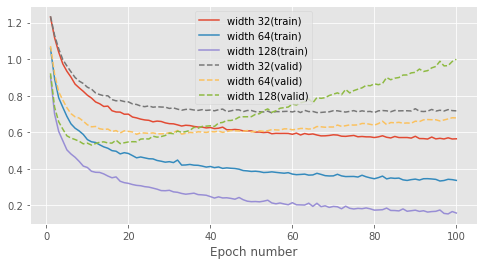

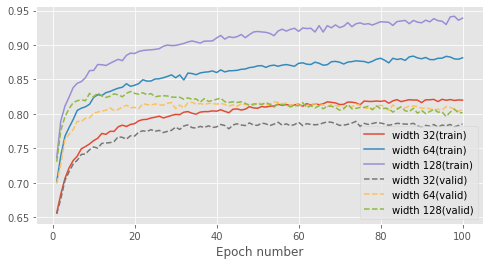

In [64]:
if data_hidden_dim is None:
    data_hidden_dim = {
        32: run_model(32, 1),
        64: run_model(64, 1),
        128: run_model(128, 1),
    }
    %store data_hidden_dim
for dim, data in data_hidden_dim.items():
    print(f"Dimension {dim} run time: {data[2]:.3f} seconds")
plot_fig_2_3(data_hidden_dim, "width")


#### Varying the Number of Hidden Layers

Layer 1 run time: 656.241 seconds
Layer 2 run time: 917.372 seconds
Layer 3 run time: 1002.711 seconds
1: error(train)=1.59e-01, acc(train)=9.39e-01, error(valid)=9.99e-01, acc(valid)=8.02e-01
2: error(train)=1.02e-01, acc(train)=9.60e-01, error(valid)=1.58e+00, acc(valid)=8.15e-01
3: error(train)=1.14e-01, acc(train)=9.57e-01, error(valid)=1.69e+00, acc(valid)=8.22e-01


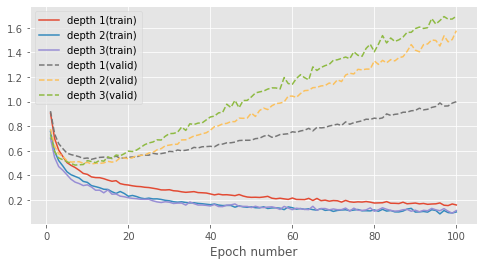

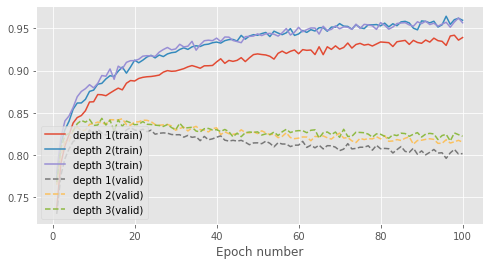

In [65]:
if data_hidden_layer is None:
    data_hidden_layer = {
        1: data_hidden_dim[128],
        2: run_model(128, 2),
        3: run_model(128, 3),
    }
    %store data_hidden_layer
for layer, data in data_hidden_layer.items():
    print(f"Layer {layer} run time: {data[2]:.3f} seconds")
plot_fig_2_3(data_hidden_layer, "depth")


#### Add Dropout

Dropout probability 0.1 with 1e-3 learning rate run time: 1006.414 seconds
Dropout probability 0.3 with 1e-3 learning rate run time: 944.262 seconds
Dropout probability 0.5 with 1e-3 learning rate run time: 938.836 seconds
Dropout probability 0.7 with 1e-3 learning rate run time: 936.055 seconds
Dropout probability 0.9 with 1e-3 learning rate run time: 942.682 seconds
Dropout 0.1 with learning rate 0.001: Accuracy 1.89e-02, Gap -4.78e-04
Dropout 0.3 with learning rate 0.001: Accuracy 2.96e-01, Gap 4.33e-02
Dropout 0.5 with learning rate 0.001: Accuracy 8.15e-01, Gap 6.62e-02
Dropout 0.7 with learning rate 0.001: Accuracy 8.47e-01, Gap 1.29e-01
Dropout 0.9 with learning rate 0.001: Accuracy 8.53e-01, Gap 2.88e-01
0.1: error(train)=5.05e+00, acc(train)=2.14e-02, error(valid)=5.05e+00, acc(valid)=1.89e-02
0.3: error(train)=2.46e+00, acc(train)=3.09e-01, error(valid)=2.50e+00, acc(valid)=2.96e-01
0.5: error(train)=5.22e-01, acc(train)=8.31e-01, error(valid)=5.88e-01, acc(valid)=8.15e-01
0.

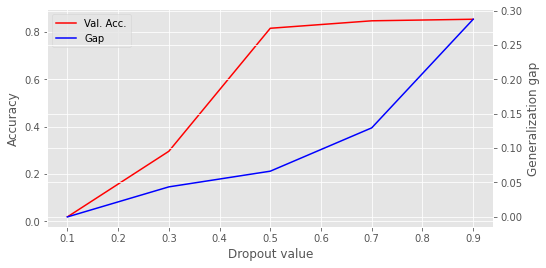

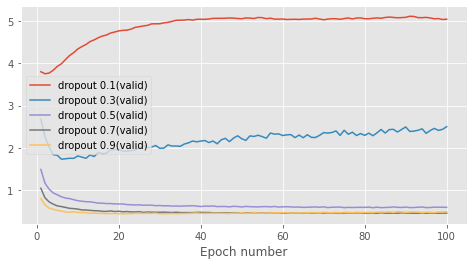

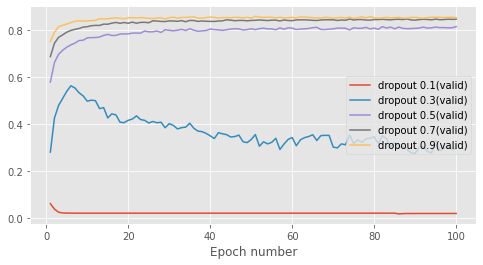

In [66]:
if data_dropout is None:
    data_dropout = {
        prob: run_model(128, 3, dropout=lambda: DropoutLayer(incl_prob=prob))
        for prob in [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    %store data_dropout
for prob, data in data_dropout.items():
    print(
        f"Dropout probability {prob} with 1e-3 learning rate run time: "
        f"{data[2]:.3f} seconds"
    )
plot_fig_4_dropout(data_dropout, 1e-3)
plot_fig_valid(data_dropout, "dropout")


#### Add Penalties

L1 penalty 1e-05 run time: 941.898 seconds
L1 penalty 0.0001 run time: 999.694 seconds
L1 penalty 0.001 run time: 981.782 seconds
L1 penalty 0.01 run time: 975.691 seconds
L1 penalty 0.1 run time: 969.017 seconds
L2 penalty 1e-05 run time: 1071.223 seconds
L2 penalty 0.0001 run time: 1081.413 seconds
L2 penalty 0.001 run time: 883.720 seconds
L2 penalty 0.01 run time: 875.483 seconds
L2 penalty 0.1 run time: 835.755 seconds
L1 1e-05 with learning rate 0.001: Accuracy 8.24e-01, Gap 7.89e-01
L1 0.0001 with learning rate 0.001: Accuracy 8.52e-01, Gap 9.15e-02
L1 0.001 with learning rate 0.001: Accuracy 7.57e-01, Gap 8.09e-03
L1 0.01 with learning rate 0.001: Accuracy 2.01e-02, Gap 7.63e-06
L1 0.1 with learning rate 0.001: Accuracy 2.16e-02, Gap 2.31e-07
L2 1e-05 with learning rate 0.001: Accuracy 8.20e-01, Gap 1.23e+00
L2 0.0001 with learning rate 0.001: Accuracy 8.31e-01, Gap 5.48e-01
L2 0.001 with learning rate 0.001: Accuracy 8.54e-01, Gap 6.36e-02
L2 0.01 with learning rate 0.001: Acc

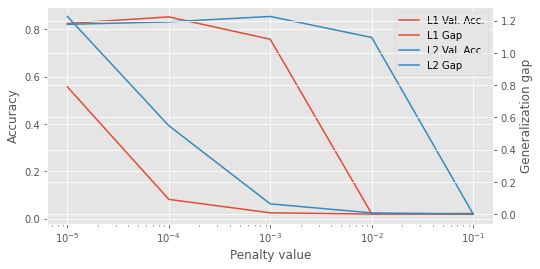

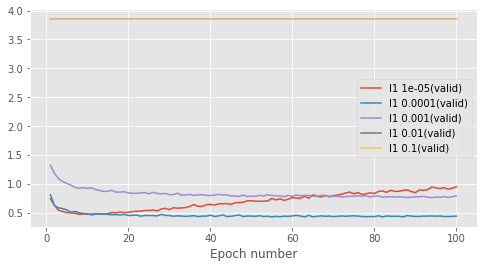

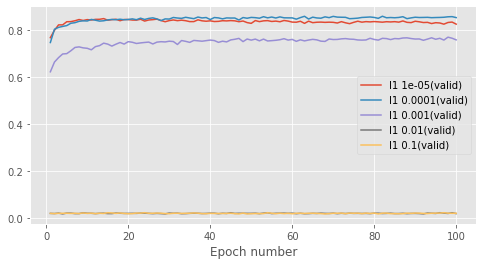

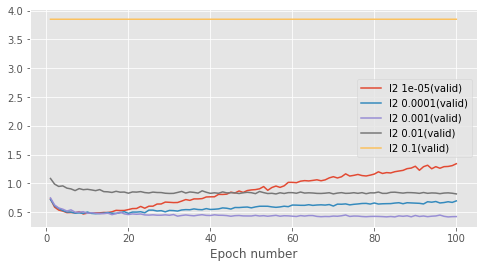

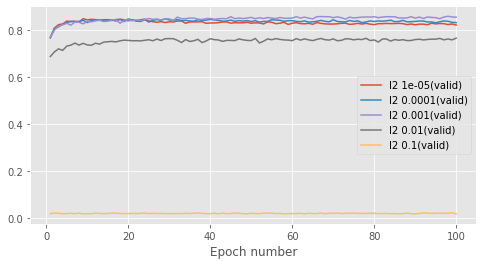

In [67]:
if data_l1 is None:
    data_l1 = {
        pen: run_model(128, 3, penalty=lambda: L1Penalty(pen))
        for pen in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }
    %store data_l1
for pen, data in data_l1.items():
    print(f"L1 penalty {pen} run time: {data[2]:.3f} seconds")

if data_l2 is None:
    data_l2 = {
        pen: run_model(128, 3, penalty=lambda: L2Penalty(pen))
        for pen in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }
    %store data_l2
for pen, data in data_l2.items():
    print(f"L2 penalty {pen} run time: {data[2]:.3f} seconds")

plot_fig_4_penalty(data_l1, data_l2, 1e-3)
plot_fig_valid(data_l1, "l1")
plot_fig_valid(data_l2, "l2")


#### Custom Models

##### Custom Model 1

In [68]:
if data_combined_1 is None:
    data_combined_1 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.5),
        penalty=lambda: L1Penalty(1e-4),
    )
    %store data_combined_1
data_combined_1_name = "Dropout 0.5 & L1 1e-4"
print(f"{data_combined_1_name}: Run time {data_combined_1[2]:.3f} seconds")
print(f"{data_combined_1_name}: {gen_acc_gap_str(data_combined_1)}")
print(f"{data_combined_1_name}: {gen_stat_str(data_combined_1)}")


Dropout 0.5 & L1 1e-4: Run time 958.392 seconds
Dropout 0.5 & L1 1e-4: Accuracy 6.58e-01, Gap 1.66e-02
Dropout 0.5 & L1 1e-4: error(train)=1.13e+00, acc(train)=6.60e-01, error(valid)=1.15e+00, acc(valid)=6.58e-01


##### Custom Model 2

In [69]:
if data_combined_2 is None:
    data_combined_2 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.5),
        penalty=lambda: L2Penalty(1e-3),
    )
    %store data_combined_2
data_combined_2_name = "Dropout 0.5 & L2 1e-3"
print(f"{data_combined_2_name}: Run time {data_combined_2[2]:.3f} seconds")
print(f"{data_combined_2_name}: {gen_acc_gap_str(data_combined_2)}")
print(f"{data_combined_2_name}: {gen_stat_str(data_combined_2)}")


Dropout 0.5 & L2 1e-3: Run time 883.383 seconds
Dropout 0.5 & L2 1e-3: Accuracy 7.38e-01, Gap 1.42e-02
Dropout 0.5 & L2 1e-3: error(train)=9.27e-01, acc(train)=7.39e-01, error(valid)=9.42e-01, acc(valid)=7.38e-01


##### Custom Model 3

In [70]:
if data_combined_3 is None:
    data_combined_3 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.7),
        penalty=lambda: L1Penalty(1e-4),
    )
    %store data_combined_3
data_combined_3_name = "Dropout 0.7 & L1 1e-4"
print(f"{data_combined_3_name}: Run time {data_combined_3[2]:.3f} seconds")
print(f"{data_combined_3_name}: {gen_acc_gap_str(data_combined_3)}")
print(f"{data_combined_3_name}: {gen_stat_str(data_combined_3)}")


Dropout 0.7 & L1 1e-4: Run time 1047.479 seconds
Dropout 0.7 & L1 1e-4: Accuracy 8.29e-01, Gap 2.74e-02
Dropout 0.7 & L1 1e-4: error(train)=4.92e-01, acc(train)=8.37e-01, error(valid)=5.20e-01, acc(valid)=8.29e-01


##### Custom Model 4

In [71]:
if data_combined_4 is None:
    data_combined_4 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.7),
        penalty=lambda: L2Penalty(1e-3),
    )
    %store data_combined_4
data_combined_4_name = "Dropout 0.7 & L2 1e-3"
print(f"{data_combined_4_name}: Run time {data_combined_4[2]:.3f} seconds")
print(f"{data_combined_4_name}: {gen_acc_gap_str(data_combined_4)}")
print(f"{data_combined_4_name}: {gen_stat_str(data_combined_4)}")


Dropout 0.7 & L2 1e-3: Run time 1079.244 seconds
Dropout 0.7 & L2 1e-3: Accuracy 8.13e-01, Gap 2.27e-02
Dropout 0.7 & L2 1e-3: error(train)=5.51e-01, acc(train)=8.20e-01, error(valid)=5.74e-01, acc(valid)=8.13e-01


##### Custom Model 5

In [72]:
if data_combined_5 is None:
    data_combined_5 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.5),
        penalty=lambda: L1Penalty(1e-5),
    )
    %store data_combined_5
data_combined_5_name = "Dropout 0.5 & L1 1e-5"
print(f"{data_combined_5_name}: Run time {data_combined_5[2]:.3f} seconds")
print(f"{data_combined_5_name}: {gen_acc_gap_str(data_combined_5)}")
print(f"{data_combined_5_name}: {gen_stat_str(data_combined_5)}")


Dropout 0.5 & L1 1e-5: Run time 1245.635 seconds
Dropout 0.5 & L1 1e-5: Accuracy 8.03e-01, Gap 4.84e-02
Dropout 0.5 & L1 1e-5: error(train)=5.85e-01, acc(train)=8.17e-01, error(valid)=6.34e-01, acc(valid)=8.03e-01


##### Custom Model 6

In [73]:
if data_combined_6 is None:
    data_combined_6 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.5),
        penalty=lambda: L2Penalty(1e-4),
    )
    %store data_combined_6
data_combined_6_name = "Dropout 0.5 & L2 1e-4"
print(f"{data_combined_6_name}: Run time {data_combined_6[2]:.3f} seconds")
print(f"{data_combined_6_name}: {gen_acc_gap_str(data_combined_6)}")
print(f"{data_combined_6_name}: {gen_stat_str(data_combined_6)}")


Dropout 0.5 & L2 1e-4: Run time 1197.134 seconds
Dropout 0.5 & L2 1e-4: Accuracy 8.01e-01, Gap 4.09e-02
Dropout 0.5 & L2 1e-4: error(train)=6.50e-01, acc(train)=8.15e-01, error(valid)=6.91e-01, acc(valid)=8.01e-01


##### Custom Model 7

In [74]:
if data_combined_7 is None:
    data_combined_7 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.7),
        penalty=lambda: L1Penalty(1e-5),
    )
    %store data_combined_7
data_combined_7_name = "Dropout 0.7 & L1 1e-5"
print(f"{data_combined_7_name}: Run time {data_combined_7[2]:.3f} seconds")
print(f"{data_combined_7_name}: {gen_acc_gap_str(data_combined_7)}")
print(f"{data_combined_7_name}: {gen_stat_str(data_combined_7)}")


Dropout 0.7 & L1 1e-5: Run time 1244.104 seconds
Dropout 0.7 & L1 1e-5: Accuracy 8.51e-01, Gap 7.89e-02
Dropout 0.7 & L1 1e-5: error(train)=3.51e-01, acc(train)=8.72e-01, error(valid)=4.30e-01, acc(valid)=8.51e-01


##### Custom Model 8

In [75]:
if data_combined_8 is None:
    data_combined_8 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.7),
        penalty=lambda: L2Penalty(1e-4),
    )
    %store data_combined_8
data_combined_8_name = "Dropout 0.5 & L2 1e-4"
print(f"{data_combined_8_name}: Run time {data_combined_8[2]:.3f} seconds")
print(f"{data_combined_8_name}: {gen_acc_gap_str(data_combined_8)}")
print(f"{data_combined_8_name}: {gen_stat_str(data_combined_8)}")


Dropout 0.5 & L2 1e-4: Run time 1314.817 seconds
Dropout 0.5 & L2 1e-4: Accuracy 8.47e-01, Gap 7.16e-02
Dropout 0.5 & L2 1e-4: error(train)=3.74e-01, acc(train)=8.68e-01, error(valid)=4.46e-01, acc(valid)=8.47e-01


### 1e-4 Learning Rate

#### Add Dropout

Dropout probability {prob} with 1e-4 learning rate run time: 885.018 seconds
Dropout probability {prob} with 1e-4 learning rate run time: 880.506 seconds
Dropout probability {prob} with 1e-4 learning rate run time: 879.015 seconds
Dropout 0.7 with learning rate 0.0001: Accuracy 8.38e-01, Gap 6.19e-02
Dropout 0.9 with learning rate 0.0001: Accuracy 8.55e-01, Gap 1.41e-01
Dropout 0.95 with learning rate 0.0001: Accuracy 8.56e-01, Gap 1.83e-01
0.7: error(train)=4.23e-01, acc(train)=8.53e-01, error(valid)=4.85e-01, acc(valid)=8.38e-01
0.9: error(train)=2.84e-01, acc(train)=8.97e-01, error(valid)=4.25e-01, acc(valid)=8.55e-01
0.95: error(train)=2.53e-01, acc(train)=9.08e-01, error(valid)=4.36e-01, acc(valid)=8.56e-01


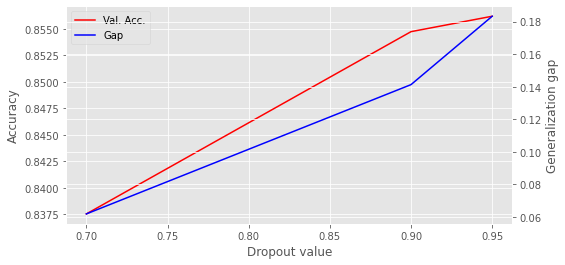

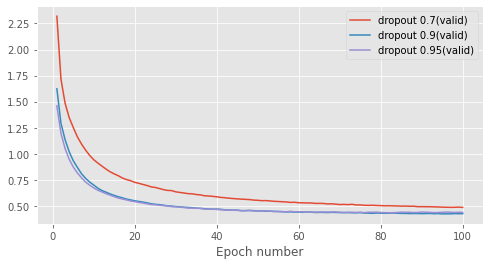

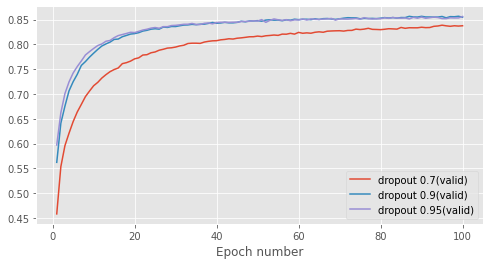

In [76]:
if data_dropout_slow is None:
    data_dropout_slow = {
        prob: run_model(
            128, 3, learning_rate=1e-4, dropout=lambda: DropoutLayer(incl_prob=prob)
        )
        for prob in [0.7, 0.9, 0.95]
    }
    %store data_dropout_slow
for prob, data in data_dropout_slow.items():
    print(
        "Dropout probability {prob} with 1e-4 learning rate run time: "
        f"{data[2]:.3f} seconds"
    )
plot_fig_4_dropout(data_dropout_slow, 1e-4)
plot_fig_valid(data_dropout_slow, "dropout")


#### Add Penalties

L1 penalty 0.0001 with 1e-4 learning rate run time: 992.300 seconds
L1 penalty 0.001 with 1e-4 learning rate run time: 992.472 seconds
L1 penalty 0.1 with 1e-4 learning rate run time: 1005.056 seconds
L2 penalty 0.0001 with 1e-4 learning rate run time: 1046.714 seconds
L2 penalty 0.001 with 1e-4 learning rate run time: 1043.921 seconds
L2 penalty 0.1 with 1e-4 learning rate run time: 863.343 seconds
L1 0.0001 with learning rate 0.0001: Accuracy 8.47e-01, Gap 7.71e-02
L1 0.001 with learning rate 0.0001: Accuracy 7.44e-01, Gap 9.70e-03
L1 0.1 with learning rate 0.0001: Accuracy 2.01e-02, Gap 7.18e-08
L2 0.0001 with learning rate 0.0001: Accuracy 8.42e-01, Gap 2.43e-01
L2 0.001 with learning rate 0.0001: Accuracy 8.48e-01, Gap 9.64e-02
L2 0.1 with learning rate 0.0001: Accuracy 2.01e-02, Gap 7.60e-05
0.0001: error(train)=3.82e-01, acc(train)=8.73e-01, error(valid)=4.59e-01, acc(valid)=8.47e-01
0.001: error(train)=8.57e-01, acc(train)=7.47e-01, error(valid)=8.67e-01, acc(valid)=7.44e-01
0.

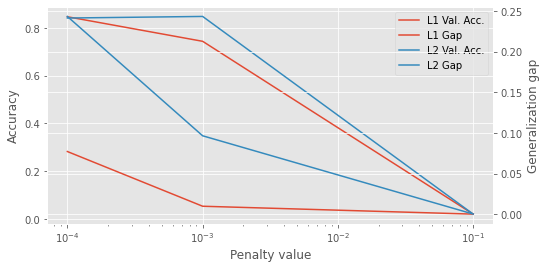

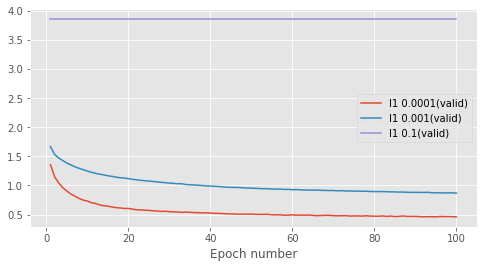

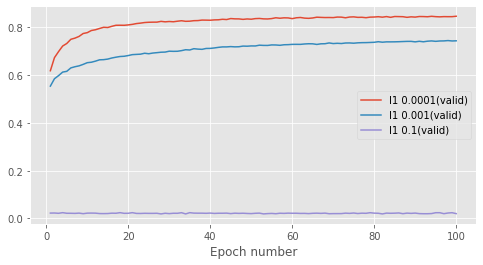

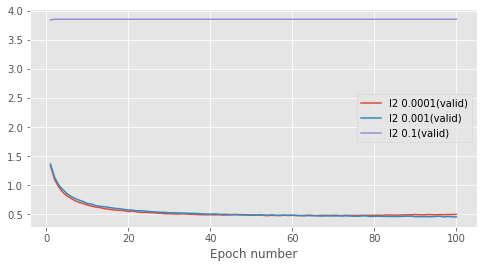

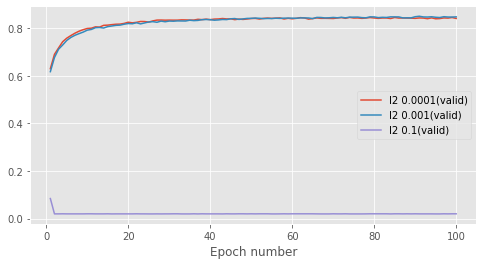

In [77]:
if data_l1_slow is None:
    data_l1_slow = {
        pen: run_model(128, 3, learning_rate=1e-4, penalty=lambda: L1Penalty(pen))
        for pen in [1e-4, 1e-3, 1e-1]
    }
    %store data_l1_slow
for pen, data in data_l1_slow.items():
    print(f"L1 penalty {pen} with 1e-4 learning rate run time: {data[2]:.3f} seconds")

if data_l2_slow is None:
    data_l2_slow = {
        pen: run_model(128, 3, learning_rate=1e-4, penalty=lambda: L2Penalty(pen))
        for pen in [1e-4, 1e-3, 1e-1]
    }
    %store data_l2_slow
for pen, data in data_l2_slow.items():
    print(f"L2 penalty {pen} with 1e-4 learning rate run time: {data[2]:.3f} seconds")

plot_fig_4_penalty(data_l1_slow, data_l2_slow, 1e-4)
plot_fig_valid(data_l1_slow, "l1")
plot_fig_valid(data_l2_slow, "l2")


#### Custom Models

##### Custom Model 1

In [78]:
if data_combined_slow_1 is None:
    data_combined_slow_1 = run_model(
        128,
        3,
        learning_rate=1e-4,
        dropout=lambda: DropoutLayer(incl_prob=0.7),
        penalty=lambda: L1Penalty(1e-4),
    )
    %store data_combined_slow_1
data_combined_slow_1_name = "Dropout 0.7 & L1 1e-4 with 1e-4 learning rate"
print(f"{data_combined_slow_1_name}: Run time {data_combined_slow_1[2]:.3f} seconds")
print(f"{data_combined_slow_1_name}: {gen_acc_gap_str(data_combined_slow_1)}")
print(f"{data_combined_slow_1_name}: {gen_stat_str(data_combined_slow_1)}")


Dropout 0.7 & L1 1e-4 with 1e-4 learning rate: Run time 1161.899 seconds
Dropout 0.7 & L1 1e-4 with 1e-4 learning rate: Accuracy 8.21e-01, Gap 2.21e-02
Dropout 0.7 & L1 1e-4 with 1e-4 learning rate: error(train)=5.25e-01, acc(train)=8.28e-01, error(valid)=5.47e-01, acc(valid)=8.21e-01


##### Custom Model 2

In [79]:
if data_combined_slow_2 is None:
    data_combined_slow_2 = run_model(
        128,
        3,
        learning_rate=1e-4,
        dropout=lambda: DropoutLayer(incl_prob=0.7),
        penalty=lambda: L1Penalty(1e-3),
    )
    %store data_combined_slow_2
data_combined_slow_2_name = "Dropout 0.7 & L1 1e-3 with 1e-4 learning rate"
print(f"{data_combined_slow_2_name}: Run time {data_combined_slow_2[2]:.3f} seconds")
print(f"{data_combined_slow_2_name}: {gen_acc_gap_str(data_combined_slow_2)}")
print(f"{data_combined_slow_2_name}: {gen_stat_str(data_combined_slow_2)}")


Dropout 0.7 & L1 1e-3 with 1e-4 learning rate: Run time 1187.417 seconds
Dropout 0.7 & L1 1e-3 with 1e-4 learning rate: Accuracy 5.73e-02, Gap -1.79e-04
Dropout 0.7 & L1 1e-3 with 1e-4 learning rate: error(train)=3.44e+00, acc(train)=6.23e-02, error(valid)=3.44e+00, acc(valid)=5.73e-02


##### Custom Model 3

In [80]:
if data_combined_slow_3 is None:
    data_combined_slow_3 = run_model(
        128,
        3,
        learning_rate=1e-4,
        dropout=lambda: DropoutLayer(incl_prob=0.7),
        penalty=lambda: L2Penalty(1e-3),
    )
    %store data_combined_slow_3
data_combined_slow_3_name = "Dropout 0.7 & L2 1e-3 with 1e-4 learning rate"
print(f"{data_combined_slow_3_name}: Run time {data_combined_slow_3[2]:.3f} seconds")
print(f"{data_combined_slow_3_name}: {gen_acc_gap_str(data_combined_slow_3)}")
print(f"{data_combined_slow_3_name}: {gen_stat_str(data_combined_slow_3)}")


Dropout 0.7 & L2 1e-3 with 1e-4 learning rate: Run time 1344.415 seconds
Dropout 0.7 & L2 1e-3 with 1e-4 learning rate: Accuracy 8.23e-01, Gap 2.67e-02
Dropout 0.7 & L2 1e-3 with 1e-4 learning rate: error(train)=5.28e-01, acc(train)=8.30e-01, error(valid)=5.54e-01, acc(valid)=8.23e-01


##### Custom Model 4

In [81]:
if data_combined_slow_4 is None:
    data_combined_slow_4 = run_model(
        128,
        3,
        learning_rate=1e-4,
        dropout=lambda: DropoutLayer(incl_prob=0.9),
        penalty=lambda: L1Penalty(1e-4),
    )
    %store data_combined_slow_4
data_combined_slow_4_name = "Dropout 0.9 & L1 1e-4 with 1e-4 learning rate"
print(f"{data_combined_slow_4_name}: Run time {data_combined_slow_4[2]:.3f} seconds")
print(f"{data_combined_slow_4_name}: {gen_acc_gap_str(data_combined_slow_4)}")
print(f"{data_combined_slow_4_name}: {gen_stat_str(data_combined_slow_4)}")


Dropout 0.9 & L1 1e-4 with 1e-4 learning rate: Run time 1164.664 seconds
Dropout 0.9 & L1 1e-4 with 1e-4 learning rate: Accuracy 8.48e-01, Gap 4.48e-02
Dropout 0.9 & L1 1e-4 with 1e-4 learning rate: error(train)=4.10e-01, acc(train)=8.61e-01, error(valid)=4.55e-01, acc(valid)=8.48e-01


##### Custom Model 5

In [82]:
if data_combined_slow_5 is None:
    data_combined_slow_5 = run_model(
        128,
        3,
        learning_rate=1e-4,
        dropout=lambda: DropoutLayer(incl_prob=0.9),
        penalty=lambda: L1Penalty(1e-3),
    )
    %store data_combined_slow_5
data_combined_slow_5_name = "Dropout 0.9 & L1 1e-3 with 1e-4 learning rate"
print(f"{data_combined_slow_5_name}: Run time {data_combined_slow_5[2]:.3f} seconds")
print(f"{data_combined_slow_5_name}: {gen_acc_gap_str(data_combined_slow_5)}")
print(f"{data_combined_slow_5_name}: {gen_stat_str(data_combined_slow_5)}")


Dropout 0.9 & L1 1e-3 with 1e-4 learning rate: Run time 1084.680 seconds
Dropout 0.9 & L1 1e-3 with 1e-4 learning rate: Accuracy 7.19e-01, Gap 3.15e-03
Dropout 0.9 & L1 1e-3 with 1e-4 learning rate: error(train)=9.82e-01, acc(train)=7.21e-01, error(valid)=9.85e-01, acc(valid)=7.19e-01


##### Custom Model 6

In [83]:
if data_combined_slow_6 is None:
    data_combined_slow_6 = run_model(
        128,
        3,
        learning_rate=1e-4,
        dropout=lambda: DropoutLayer(incl_prob=0.9),
        penalty=lambda: L2Penalty(1e-3),
    )
    %store data_combined_slow_6
data_combined_slow_6_name = "Dropout 0.9 & L2 1e-3 with 1e-4 learning rate"
print(f"{data_combined_slow_6_name}: Run time {data_combined_slow_6[2]:.3f} seconds")
print(f"{data_combined_slow_6_name}: {gen_acc_gap_str(data_combined_slow_6)}")
print(f"{data_combined_slow_6_name}: {gen_stat_str(data_combined_slow_6)}")


Dropout 0.9 & L2 1e-3 with 1e-4 learning rate: Run time 1233.102 seconds
Dropout 0.9 & L2 1e-3 with 1e-4 learning rate: Accuracy 8.45e-01, Gap 5.85e-02
Dropout 0.9 & L2 1e-3 with 1e-4 learning rate: error(train)=4.02e-01, acc(train)=8.66e-01, error(valid)=4.60e-01, acc(valid)=8.45e-01
